# Import

In [39]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [40]:
def fetch_data_from_disk(results_path, times_path):
    # Set style for better-looking plots
    sns.set_style("whitegrid")
    plt.rcParams["figure.figsize"] = (14, 6)

    # Load the JSON files
    results_path = Path(results_path)
    times_path = Path(times_path)

    with open(results_path, "r") as f:
        results_data = json.load(f)

    with open(times_path, "r") as f:
        times_data = json.load(f)

    print("Data loaded successfully!")
    print(f"Number of clients: {len(results_data)}")
    print(
        f"Number of rounds: {max([int(round_key) for client in results_data.values() for round_key in client.keys()])}"
    )

    return results_data, times_data

In [41]:
def processed_data(results_data, times_data):
    # Process results data - calculate average accuracy and loss per round
    rounds_data = []

    # Get unique rounds from results_data
    unique_rounds = sorted(
        set(
            [
                int(r)
                for client_data in results_data.values()
                for r in client_data.keys()
            ]
        ),
        key=int,
    )

    for round_num in unique_rounds:
        round_str = str(round_num)

        # Collect metrics from all clients for this round
        accuracies = []
        losses = []

        for client_num, client_data in results_data.items():
            if round_str in client_data:
                metrics = client_data[round_str]["metrics"]
                accuracies.append(metrics["accuracy"])
                losses.append(metrics["loss"])

        # Calculate averages
        if accuracies and losses:
            avg_accuracy = np.mean(accuracies)
            avg_loss = np.mean(losses)
            round_time = float(times_data.get(round_str, 0))

            rounds_data.append(
                {
                    "round": round_num,
                    "avg_accuracy": avg_accuracy,
                    "avg_loss": avg_loss,
                    "round_time": round_time,
                    "num_clients": len(accuracies),
                }
            )

    # Create DataFrame
    df_rounds = pd.DataFrame(rounds_data)

    print("Processed data summary:")
    print(f"Total rounds: {len(df_rounds)}")
    print(f"\nFirst 5 rounds:")
    print(df_rounds.head())
    print(f"\nLast 5 rounds:")
    print(df_rounds.tail())
    print(f"\nStatistics:")
    print(df_rounds[["avg_accuracy", "avg_loss", "round_time"]].describe())

    return df_rounds

In [42]:
def plot_metrics(df_rounds):
    # Create side-by-side plots for Accuracy and Loss
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # Plot 1: Average Accuracy per Round
    axes[0].plot(
        df_rounds["round"],
        df_rounds["avg_accuracy"],
        linewidth=2,
        marker="o",
        markersize=3,
        color="#2E86AB",
    )
    axes[0].fill_between(
        df_rounds["round"], df_rounds["avg_accuracy"], alpha=0.3, color="#2E86AB"
    )
    axes[0].set_xlabel("Round Number", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Average Accuracy", fontsize=12, fontweight="bold")
    axes[0].set_title(
        "Average Accuracy Across Clients per Round", fontsize=14, fontweight="bold"
    )
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xlim(0, df_rounds["round"].max())

    # Add annotations for min and max accuracy
    max_acc_idx = df_rounds["avg_accuracy"].idxmax()
    min_acc_idx = df_rounds["avg_accuracy"].idxmin()
    axes[0].scatter(
        df_rounds.loc[max_acc_idx, "round"],
        df_rounds.loc[max_acc_idx, "avg_accuracy"],
        color="green",
        s=100,
        zorder=5,
        label=f"Max: {df_rounds.loc[max_acc_idx, 'avg_accuracy']:.4f}",
    )
    axes[0].scatter(
        df_rounds.loc[min_acc_idx, "round"],
        df_rounds.loc[min_acc_idx, "avg_accuracy"],
        color="red",
        s=100,
        zorder=5,
        label=f"Min: {df_rounds.loc[min_acc_idx, 'avg_accuracy']:.4f}",
    )
    axes[0].legend(loc="lower right")

    # Plot 2: Average Loss per Round
    axes[1].plot(
        df_rounds["round"],
        df_rounds["avg_loss"],
        linewidth=2,
        marker="o",
        markersize=3,
        color="#A23B72",
    )
    axes[1].fill_between(
        df_rounds["round"], df_rounds["avg_loss"], alpha=0.3, color="#A23B72"
    )
    axes[1].set_xlabel("Round Number", fontsize=12, fontweight="bold")
    axes[1].set_ylabel("Average Loss", fontsize=12, fontweight="bold")
    axes[1].set_title(
        "Average Loss Across Clients per Round", fontsize=14, fontweight="bold"
    )
    axes[1].grid(True, alpha=0.3)
    axes[1].set_xlim(0, df_rounds["round"].max())

    # Add annotations for min and max loss
    max_loss_idx = df_rounds["avg_loss"].idxmax()
    min_loss_idx = df_rounds["avg_loss"].idxmin()
    axes[1].scatter(
        df_rounds.loc[max_loss_idx, "round"],
        df_rounds.loc[max_loss_idx, "avg_loss"],
        color="red",
        s=100,
        zorder=5,
        label=f"Max: {df_rounds.loc[max_loss_idx, 'avg_loss']:.4f}",
    )
    axes[1].scatter(
        df_rounds.loc[min_loss_idx, "round"],
        df_rounds.loc[min_loss_idx, "avg_loss"],
        color="green",
        s=100,
        zorder=5,
        label=f"Min: {df_rounds.loc[min_loss_idx, 'avg_loss']:.4f}",
    )
    axes[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    print(f"Final Round Accuracy: {df_rounds.iloc[-1]['avg_accuracy']:.4f}")
    print(f"Final Round Loss: {df_rounds.iloc[-1]['avg_loss']:.6f}")

In [43]:
def plot_execution_time(df_rounds):
    # Plot Round Execution Times
    fig, ax = plt.subplots(figsize=(14, 6))

    ax.bar(
        df_rounds["round"],
        df_rounds["round_time"],
        color="#F18F01",
        alpha=0.7,
        edgecolor="black",
        linewidth=0.5,
    )
    ax.set_xlabel("Round Number", fontsize=12, fontweight="bold")
    ax.set_ylabel("Time (seconds)", fontsize=12, fontweight="bold")
    ax.set_title("Communication Round Times", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3, axis="y")

    # Add statistics
    mean_time = df_rounds["round_time"].mean()
    ax.axhline(
        y=mean_time,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {mean_time:.2f}s",
    )
    ax.legend(fontsize=11)

    plt.tight_layout()
    plt.show()

    print(f"\n=== TIMING SUMMARY ===")
    print(f"Average Round Time: {mean_time:.2f} seconds")
    print(f"Min Round Time: {df_rounds['round_time'].min():.2f} seconds")
    print(f"Max Round Time: {df_rounds['round_time'].max():.2f} seconds")

    total_seconds = df_rounds["round_time"].sum()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    print(
        f"Total Training Time: {total_seconds:.2f} seconds ({minutes}m {seconds:.2f}s)"
    )

# Federated Learning Results Analysis - MNIST Default on 5 clients


In [44]:
default_results_path = "../src/plots/mnist_default_5_results.json"
default_times_path = "../src/plots/mnist_default_5_round_times.json"

default_results_data, default_times_data = fetch_data_from_disk(
    default_results_path, default_times_path
)

Data loaded successfully!
Number of clients: 5
Number of rounds: 200


In [45]:
default_df_rounds = processed_data(default_results_data, default_times_data)

Processed data summary:
Total rounds: 200

First 5 rounds:
   round  avg_accuracy  avg_loss  round_time  num_clients
0      1        0.1325  0.035435   55.848881            5
1      2        0.2440  0.032177   30.127671            5
2      3        0.4857  0.025465   41.226990            5
3      4        0.6502  0.018704   50.287588            5
4      5        0.6855  0.015542   53.485804            5

Last 5 rounds:
     round  avg_accuracy  avg_loss  round_time  num_clients
195    196        0.9591  0.002093   52.844923            5
196    197        0.9580  0.002111   52.184630            5
197    198        0.9562  0.002264   51.518511            5
198    199        0.9588  0.002083   49.801095            5
199    200        0.9579  0.002137   53.519719            5

Statistics:
       avg_accuracy    avg_loss  round_time
count    200.000000  200.000000  200.000000
mean       0.909031    0.004286   52.882975
std        0.093660    0.004125    2.451244
min        0.132500    0.002

## Average Accuracy and Loss Across Rounds

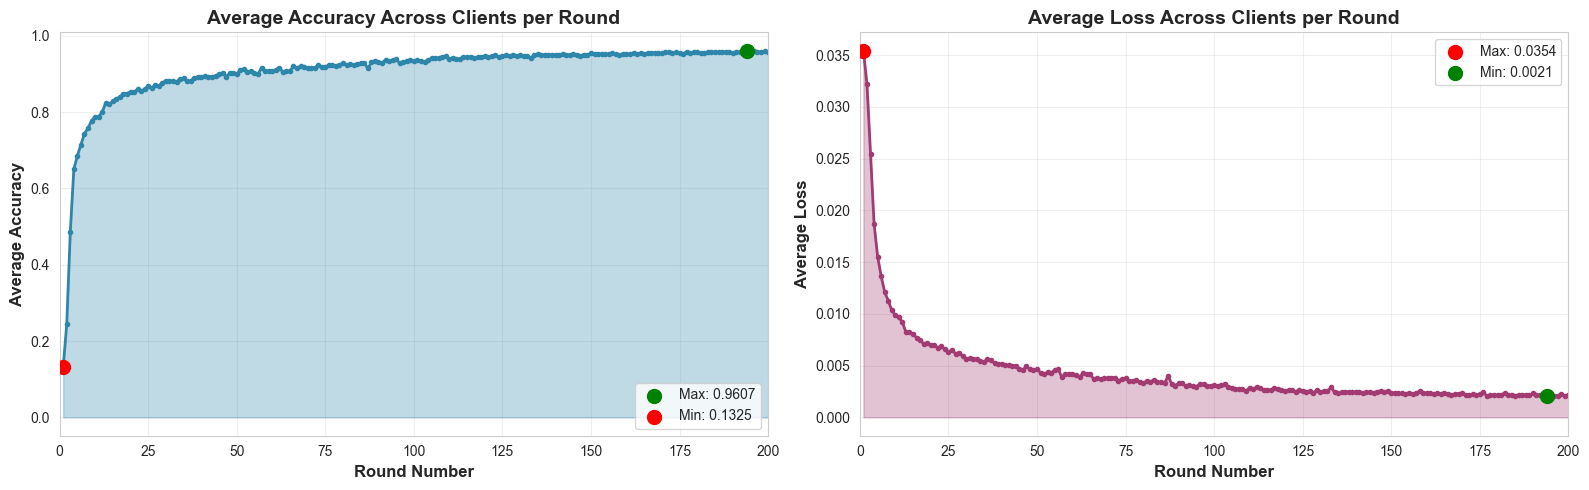

Final Round Accuracy: 0.9579
Final Round Loss: 0.002137


In [46]:
plot_metrics(default_df_rounds)

## Round Execution Times

The plot below shows the time taken for each communication round during federated learning.

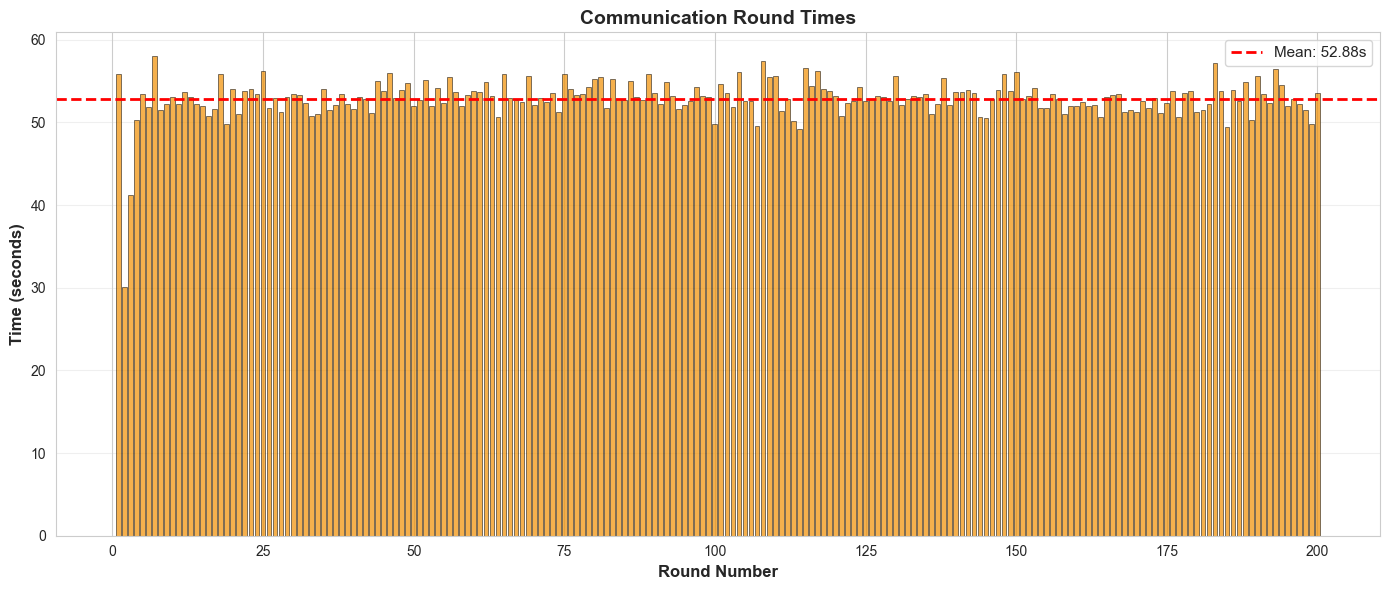


=== TIMING SUMMARY ===
Average Round Time: 52.88 seconds
Min Round Time: 30.13 seconds
Max Round Time: 57.99 seconds
Total Training Time: 10576.59 seconds (176m 16.59s)


In [47]:
plot_execution_time(default_df_rounds)

# Federated Learning Results Analysis - MNIST HFedCVAE on 5 clients


In [48]:
HFedCVAE_results_path = "../src/plots/mnist_HFedCVAE_5_results.json"
HFedCVAE_times_path = "../src/plots/mnist_HFedCVAE_5_round_times.json"

HFedCVAE_results_data, HFedCVAE_times_data = fetch_data_from_disk(
    HFedCVAE_results_path, HFedCVAE_times_path
)

Data loaded successfully!
Number of clients: 5
Number of rounds: 100


In [60]:
HFedCVAE_df_rounds = processed_data(HFedCVAE_results_data, HFedCVAE_times_data)
HFedCVAE_df_rounds = HFedCVAE_df_rounds.iloc[:-75]

Processed data summary:
Total rounds: 100

First 5 rounds:
   round  avg_accuracy   avg_loss  round_time  num_clients
0      1       0.09800  14.190957   45.434444            5
1      2       0.21116   0.627744   27.875887            5
2      3       0.31152   0.211664   19.207486            5
3      4       0.40818   0.173408   19.255138            5
4      5       0.50356   0.212995   27.587351            5

Last 5 rounds:
    round  avg_accuracy  avg_loss  round_time  num_clients
95     96        0.9707  0.001413   50.532403            5
96     97        0.9709  0.001410   48.416936            5
97     98        0.9707  0.001407   53.978184            5
98     99        0.9708  0.001406   51.969835            5
99    100        0.9711  0.001403   51.621590            5

Statistics:
       avg_accuracy    avg_loss  round_time
count    100.000000  100.000000  100.000000
mean       0.924282    0.160869   51.771147
std        0.155378    1.419171   20.546208
min        0.098000    0.001

## Average Accuracy and Loss Across Rounds

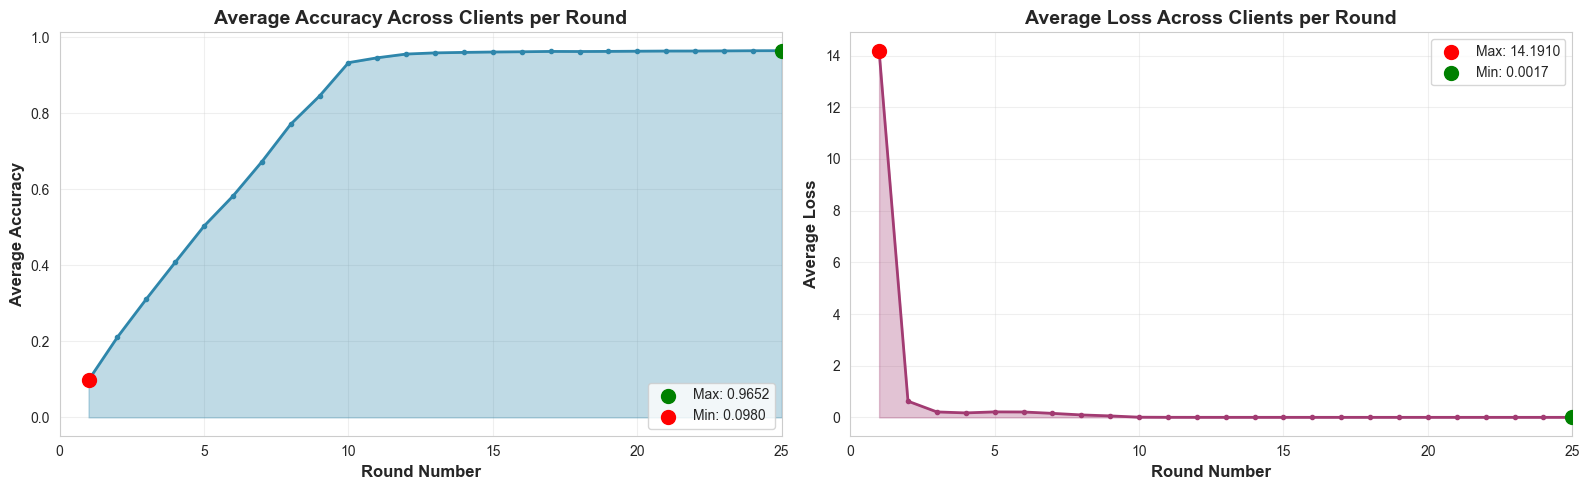

Final Round Accuracy: 0.9652
Final Round Loss: 0.001729


In [61]:
plot_metrics(HFedCVAE_df_rounds)

## Round Execution Times

The plot below shows the time taken for each communication round during federated learning.

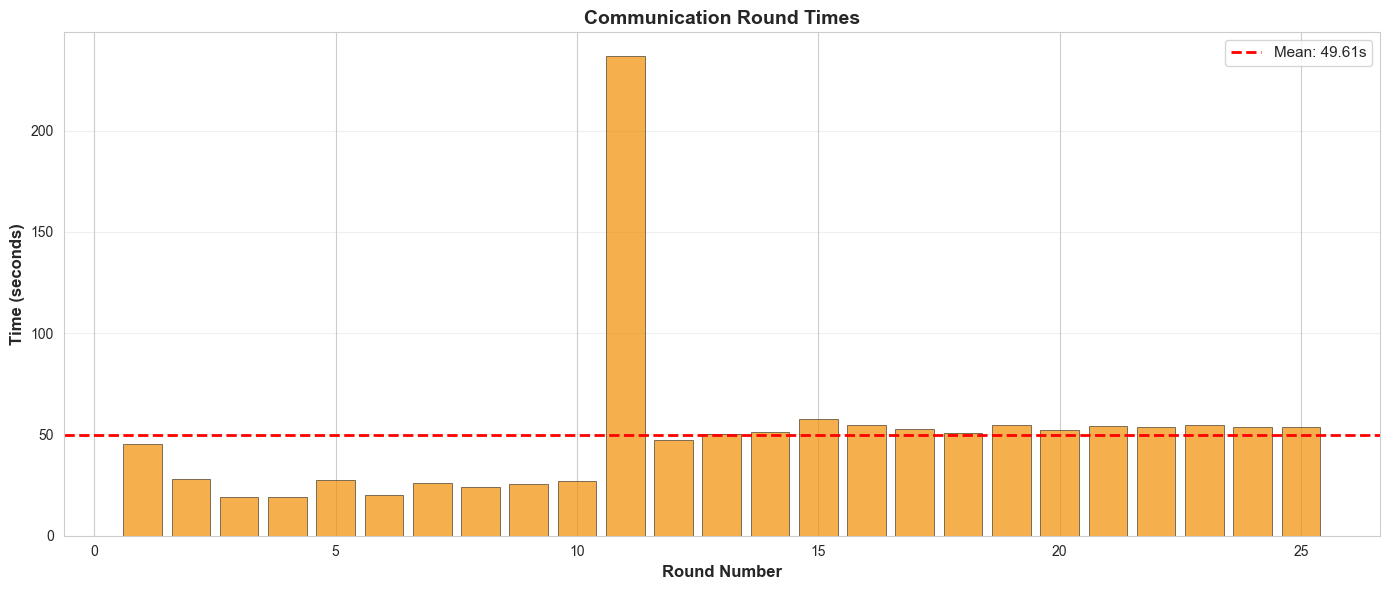


=== TIMING SUMMARY ===
Average Round Time: 49.61 seconds
Min Round Time: 19.21 seconds
Max Round Time: 236.75 seconds
Total Training Time: 1240.24 seconds (20m 40.24s)


In [62]:
plot_execution_time(HFedCVAE_df_rounds)

# Model Comparison: Default vs HFedCVAE

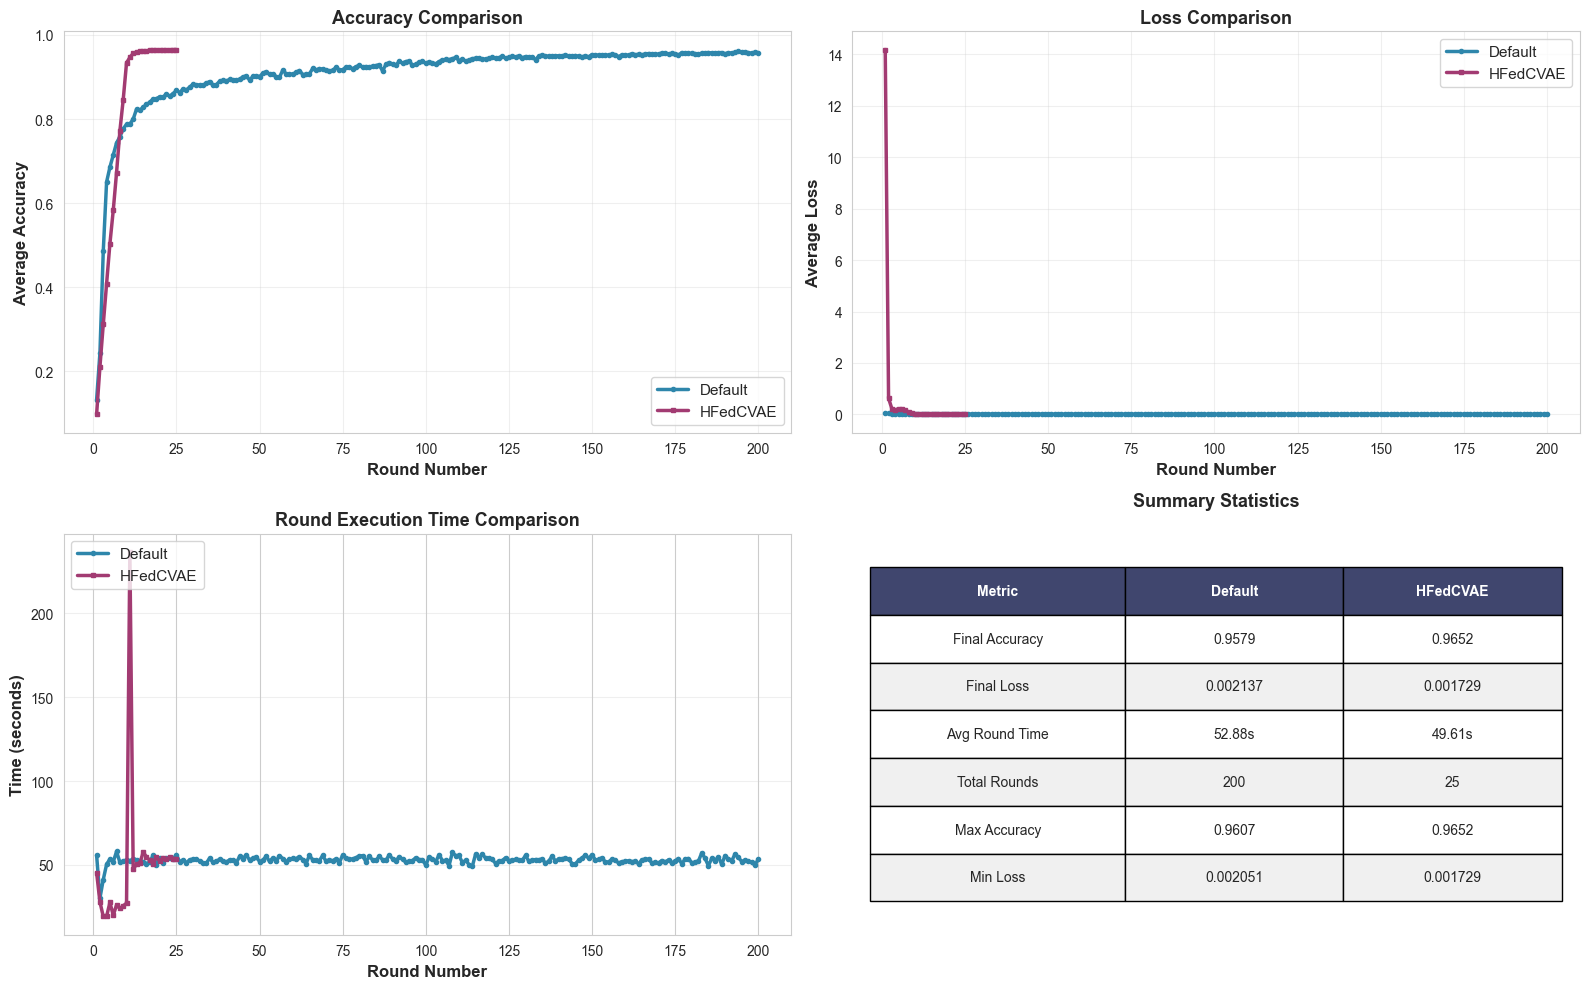


MODEL COMPARISON SUMMARY

Default Model:
  Final Accuracy: 0.9579
  Final Loss: 0.002137
  Total Rounds: 200
  Avg Round Time: 52.88s

HFedCVAE Model:
  Final Accuracy: 0.9652
  Final Loss: 0.001729
  Total Rounds: 25
  Avg Round Time: 49.61s

Accuracy Difference (HFedCVAE - Default): +0.0073


In [ ]:
def plot_model_comparison(default_df, hfedcvae_df):
    """
    Compare accuracy and loss metrics between Default and HFedCVAE models side-by-side
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # Plot 1: Accuracy Comparison
    axes[0, 0].plot(
        default_df["round"],
        default_df["avg_accuracy"],
        linewidth=2.5,
        marker="o",
        markersize=3,
        color="#2E86AB",
        label="Default",
    )
    axes[0, 0].plot(
        hfedcvae_df["round"],
        hfedcvae_df["avg_accuracy"],
        linewidth=2.5,
        marker="s",
        markersize=3,
        color="#A23B72",
        label="HFedCVAE",
    )
    axes[0, 0].set_xlabel("Round Number", fontsize=12, fontweight="bold")
    axes[0, 0].set_ylabel("Average Accuracy", fontsize=12, fontweight="bold")
    axes[0, 0].set_title("Accuracy Comparison", fontsize=13, fontweight="bold")
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend(fontsize=11, loc="lower right")

    # Plot 2: Loss Comparison
    axes[0, 1].plot(
        default_df["round"],
        default_df["avg_loss"],
        linewidth=2.5,
        marker="o",
        markersize=3,
        color="#2E86AB",
        label="Default",
    )
    axes[0, 1].plot(
        hfedcvae_df["round"],
        hfedcvae_df["avg_loss"],
        linewidth=2.5,
        marker="s",
        markersize=3,
        color="#A23B72",
        label="HFedCVAE",
    )
    axes[0, 1].set_xlabel("Round Number", fontsize=12, fontweight="bold")
    axes[0, 1].set_ylabel("Average Loss", fontsize=12, fontweight="bold")
    axes[0, 1].set_title("Loss Comparison", fontsize=13, fontweight="bold")
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend(fontsize=11, loc="upper right")

    # Plot 3: Round Time Comparison
    axes[1, 0].plot(
        default_df["round"],
        default_df["round_time"],
        linewidth=2.5,
        marker="o",
        markersize=3,
        color="#2E86AB",
        label="Default",
    )
    axes[1, 0].plot(
        hfedcvae_df["round"],
        hfedcvae_df["round_time"],
        linewidth=2.5,
        marker="s",
        markersize=3,
        color="#A23B72",
        label="HFedCVAE",
    )
    axes[1, 0].set_xlabel("Round Number", fontsize=12, fontweight="bold")
    axes[1, 0].set_ylabel("Time (seconds)", fontsize=12, fontweight="bold")
    axes[1, 0].set_title(
        "Round Execution Time Comparison", fontsize=13, fontweight="bold"
    )
    axes[1, 0].grid(True, alpha=0.3, axis="y")
    axes[1, 0].legend(fontsize=11, loc="upper left")

    # Plot 4: Summary Statistics Table
    axes[1, 1].axis("off")
    summary_data = [
        ["Metric", "Default", "HFedCVAE"],
        [
            "Final Accuracy",
            f"{default_df.iloc[-1]['avg_accuracy']:.4f}",
            f"{hfedcvae_df.iloc[-1]['avg_accuracy']:.4f}",
        ],
        [
            "Final Loss",
            f"{default_df.iloc[-1]['avg_loss']:.6f}",
            f"{hfedcvae_df.iloc[-1]['avg_loss']:.6f}",
        ],
        [
            "Avg Round Time",
            f"{default_df['round_time'].mean():.2f}s",
            f"{hfedcvae_df['round_time'].mean():.2f}s",
        ],
        ["Total Rounds", f"{len(default_df)}", f"{len(hfedcvae_df)}"],
        [
            "Max Accuracy",
            f"{default_df['avg_accuracy'].max():.4f}",
            f"{hfedcvae_df['avg_accuracy'].max():.4f}",
        ],
        [
            "Min Loss",
            f"{default_df['avg_loss'].min():.6f}",
            f"{hfedcvae_df['avg_loss'].min():.6f}",
        ],
    ]

    table = axes[1, 1].table(
        cellText=summary_data,
        cellLoc="center",
        loc="center",
        colWidths=[0.35, 0.3, 0.3],
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)

    # Style header row
    for i in range(3):
        table[(0, i)].set_facecolor("#40466e")
        table[(0, i)].set_text_props(weight="bold", color="white")

    # Alternate row colors
    for i in range(1, len(summary_data)):
        for j in range(3):
            if i % 2 == 0:
                table[(i, j)].set_facecolor("#f0f0f0")
            else:
                table[(i, j)].set_facecolor("#ffffff")

    axes[1, 1].set_title("Summary Statistics", fontsize=13, fontweight="bold", pad=20)

    plt.tight_layout()
    plt.show()

    # Print comparison summary
    print("\n" + "=" * 60)
    print("MODEL COMPARISON SUMMARY")
    print("=" * 60)
    print(f"\nDefault Model:")
    print(f"  Final Accuracy: {default_df.iloc[-1]['avg_accuracy']:.4f}")
    print(f"  Final Loss: {default_df.iloc[-1]['avg_loss']:.6f}")
    print(f"  Total Rounds: {len(default_df)}")
    print(f"  Avg Round Time: {default_df['round_time'].mean():.2f}s")

    print(f"\nHFedCVAE Model:")
    print(f"  Final Accuracy: {hfedcvae_df.iloc[-1]['avg_accuracy']:.4f}")
    print(f"  Final Loss: {hfedcvae_df.iloc[-1]['avg_loss']:.6f}")
    print(f"  Total Rounds: {len(hfedcvae_df)}")
    print(f"  Avg Round Time: {hfedcvae_df['round_time'].mean():.2f}s")

    acc_diff = (
        hfedcvae_df.iloc[-1]["avg_accuracy"] - default_df.iloc[-1]["avg_accuracy"]
    )
    print(f"\nAccuracy Difference (HFedCVAE - Default): {acc_diff:+.4f}")
    print("=" * 60)


# Create the comparison plot
plot_model_comparison(default_df_rounds, HFedCVAE_df_rounds)